In [8]:
import os

from scipy import stats
import pandas as pd
import numpy as np
from rocketlogger.data import RocketLoggerData

import matplotlib as mpl
import matplotlib.pyplot as plt

import yaml
try:
    from yaml import CLoader as Loader
except ImportErorr:
    from yaml import Loader

In [9]:
# Set plot size
factor = 1.2
default_dpi = mpl.rcParamsDefault['figure.dpi']
mpl.rcParams['figure.dpi'] = default_dpi*factor

In [10]:
def load_rld(path, channel, start, stop, step):
    """Loads rocketlogger data from csv and truncates to the nearest step in the SMU.
    
    Parameters
    ----------
    path : str
        Path to rocketlogger binary data
    start : float
        Starting source value
    stop : float
        Stopping source value
    step : float
        Step source value
        
    Returns
    -------
    pd.DataFrame
        Dataframe of rocketlogger data
    """
    
    # Load RL binary data
    rld = RocketLoggerData(path)
    
    source_range = np.arange(start, stop, step)
    
    def estimate_input(x):
        """Estimate the input voltage based on measure voltage

        Parameters
        ----------
        x : float
            Inputted row

        Returns
        -------
        float
            Closest value to v_range
        """

        diff = np.abs(source_range - x)
        idx = np.argmin(diff)
        return source_range[idx]

    rld_df = pd.DataFrame(rld.get_data(), columns=rld.get_channel_names())
    rld_df["source"] = rld_df[channel].apply(estimate_input)
    rld_df = rld_df.set_index("source")
    return rld_df

In [11]:
def plot_accuracy(x, y):
    """Plots a graph showing the accuracy of measurements y to ideal values x
    
    Parameters
    ----------
    x : Series
        True values
    y : Series
        Measured values
        
    Returns
    -------
    fig, ax
        Matplotlib figure, same format as plt.subplots
    """
    
    rel = y / x
    rel = rel.groupby("source").describe()
    
    fig, ax = plt.subplots()
    ax.errorbar(rel.index, rel["mean"], yerr=rel["std"])
    ax.axhline(y=1, linestyle=':', color='k', linewidth='3')
    ax.grid()
    
    return (fig, ax)

Text(0, 0.5, 'Relative measurement (V/V)')

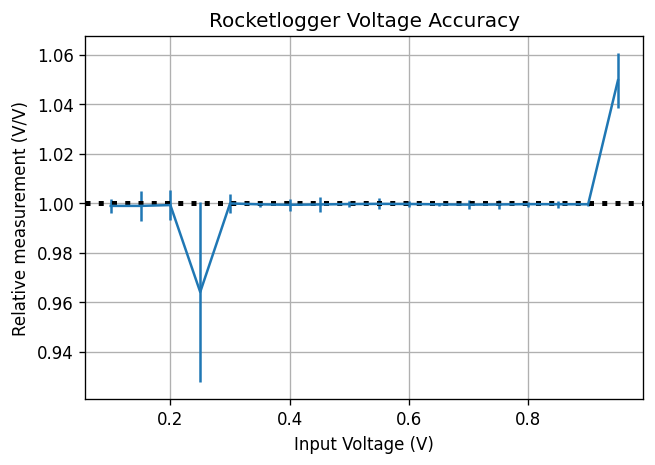

In [12]:
rld_v = load_rld("data/rl/20220825_231144_eval_v.rld", "V1", 0.1, 1, 0.05)
fig, ax = plot_accuracy(rld_v.index, rld_v["V1"])
ax.set_title("Rocketlogger Voltage Accuracy")
ax.set_xlabel("Input Voltage (V)")
ax.set_ylabel("Relative measurement (V/V)")

Text(0, 0.5, 'Relative measurement (V/V)')

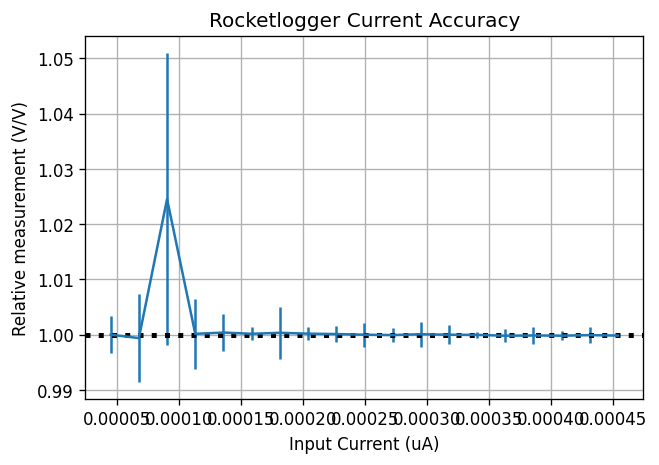

In [25]:
rld_i = load_rld("data/rl/20220826_163200_eval_i.rld", "I1L", 45e-6, 454e-6, 22.7222e-6)
fig, ax = plot_accuracy(rld_i.index, rld_i["I1L"])
ax.set_title("Rocketlogger Current Accuracy")
ax.set_xlabel("Input Current (uA)")
ax.set_ylabel("Relative measurement (V/V)")